In [1]:
from datasets import Dataset, load_dataset, DatasetDict, ClassLabel
import numpy as np
import torch
import pandas as pd

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
function_mapping = {'OTHER': ['joy', 'love', 'surprise'],
           'NOT_INTERESTED': [''], 
           'DISLIKE':[''], 
           'NOT_CORRECT': [''], 
           'PESSIMISTIC':['sadness'], 
           'WORRIED':['fear'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': [''], 
           'BORED': [''], 
           'NOT_APPROVE':[''], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': [''], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

emotion = load_dataset('emotion')
mapping = {
    0:"sadness",
    1:"joy",
    2:"love",
    3:"anger",
    4:"fear",
    5:"surprise"
}
emotion = emotion.map(lambda example: {'emotion': mapping[example['label']]}, 
                      remove_columns=['label'])
def map_labels(batch):
    batch['function'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["function"]):
        for key, value in function_mapping.items():
            for emotion in value:
                if emotion == batch["emotion"][i]:
                    batch["function"][i] = key
                    break
    return batch
emotion = emotion.map(map_labels, batched=True)

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████| 3/3 [00:00<00:00, 75.47it/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-da33b75eb48814c5.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-c9fa37d993431ea5.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-9e625d0ab4c5791f.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c6709727

In [3]:
emotion['train'][53]

{'text': 'i was stymied a little bit as i wrote feeling unsure that i might go somewhere with the story unintended',
 'emotion': 'fear',
 'function': 'WORRIED'}

In [4]:
emotion = emotion.class_encode_column("function")
labels = emotion['train'].features['function']
emotion = emotion.rename_column("function", "label")
print(labels.names)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-4648c3bafb1d725c.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-390eecc66e407e1e.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-ca76f14b12e0a0c9.arrow


['ANGRY', 'OTHER', 'PESSIMISTIC', 'WORRIED']


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

transformer_model = 'cardiffnlp/twitter-xlm-roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model, num_labels = len(labels.names))).to(device)
tokenizer=AutoTokenizer.from_pretrained(transformer_model)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

ds_enc = emotion.map(tokenize, batched=True, batch_size=None)
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")
ds_enc

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

DatasetDict({
    train: Dataset({
        features: ['text', 'emotion', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'emotion', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'emotion', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [6]:
from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [7]:
from transformers import TrainingArguments, Trainer

batch_size = 16
model_name = "baseline_functions"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,        
        report_to='none',
    )

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["validation"],                    
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotion, text. If emotion, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/njfernandez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
  Number of trainable parameters = 278046724
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.663500,0.192498,0.918214,0.919640,0.918578
2,0.137500,0.139399,0.944187,0.934937,0.939339
3,0.082800,0.112631,0.941184,0.957507,0.948612
4,0.060400,0.097687,0.951882,0.938349,0.944479
5,0.040100,0.111264,0.940744,0.949023,0.944217


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotion, text. If emotion, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to baseline_functions/checkpoint-500
Configuration saved in baseline_functions/checkpoint-500/config.json
Model weights saved in baseline_functions/checkpoint-500/pytorch_model.bin
tokenizer config file saved in baseline_functions/checkpoint-500/tokenizer_config.json
Special tokens file saved in baseline_functions/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [baseline_functions/checkpoint-1500] due to args.save_total_limit
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were sc

TrainOutput(global_step=2500, training_loss=0.19684345092773436, metrics={'train_runtime': 1054.3425, 'train_samples_per_second': 75.877, 'train_steps_per_second': 2.371, 'total_flos': 3535618295040000.0, 'train_loss': 0.19684345092773436, 'epoch': 5.0})

In [8]:
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotion, text. If emotion, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.110099196434021, 'test_precision': 0.9398630753596793, 'test_recall': 0.9585222808228964, 'test_f1': 0.9484935546585442, 'test_runtime': 8.1171, 'test_samples_per_second': 246.392, 'test_steps_per_second': 7.761}


In [9]:
from sklearn.metrics import classification_report

y_true = np.array(ds_enc['test']["label"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

              precision    recall  f1-score   support

       ANGRY       0.92      0.93      0.92       275
       OTHER       0.99      0.97      0.98       920
 PESSIMISTIC       0.97      0.97      0.97       581
     WORRIED       0.88      0.97      0.92       224

    accuracy                           0.96      2000
   macro avg       0.94      0.96      0.95      2000
weighted avg       0.96      0.96      0.96      2000



In [10]:
report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0,
    output_dict=True
)

df = pd.DataFrame(report).transpose()
with open(r'classification_report_baseline_emotion_en_finetuning.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, labels):    
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(50, 50))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)  
    font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}
    plt.rc('font', **font)
    ax.tick_params(axis='x', which='major', labelsize=15)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

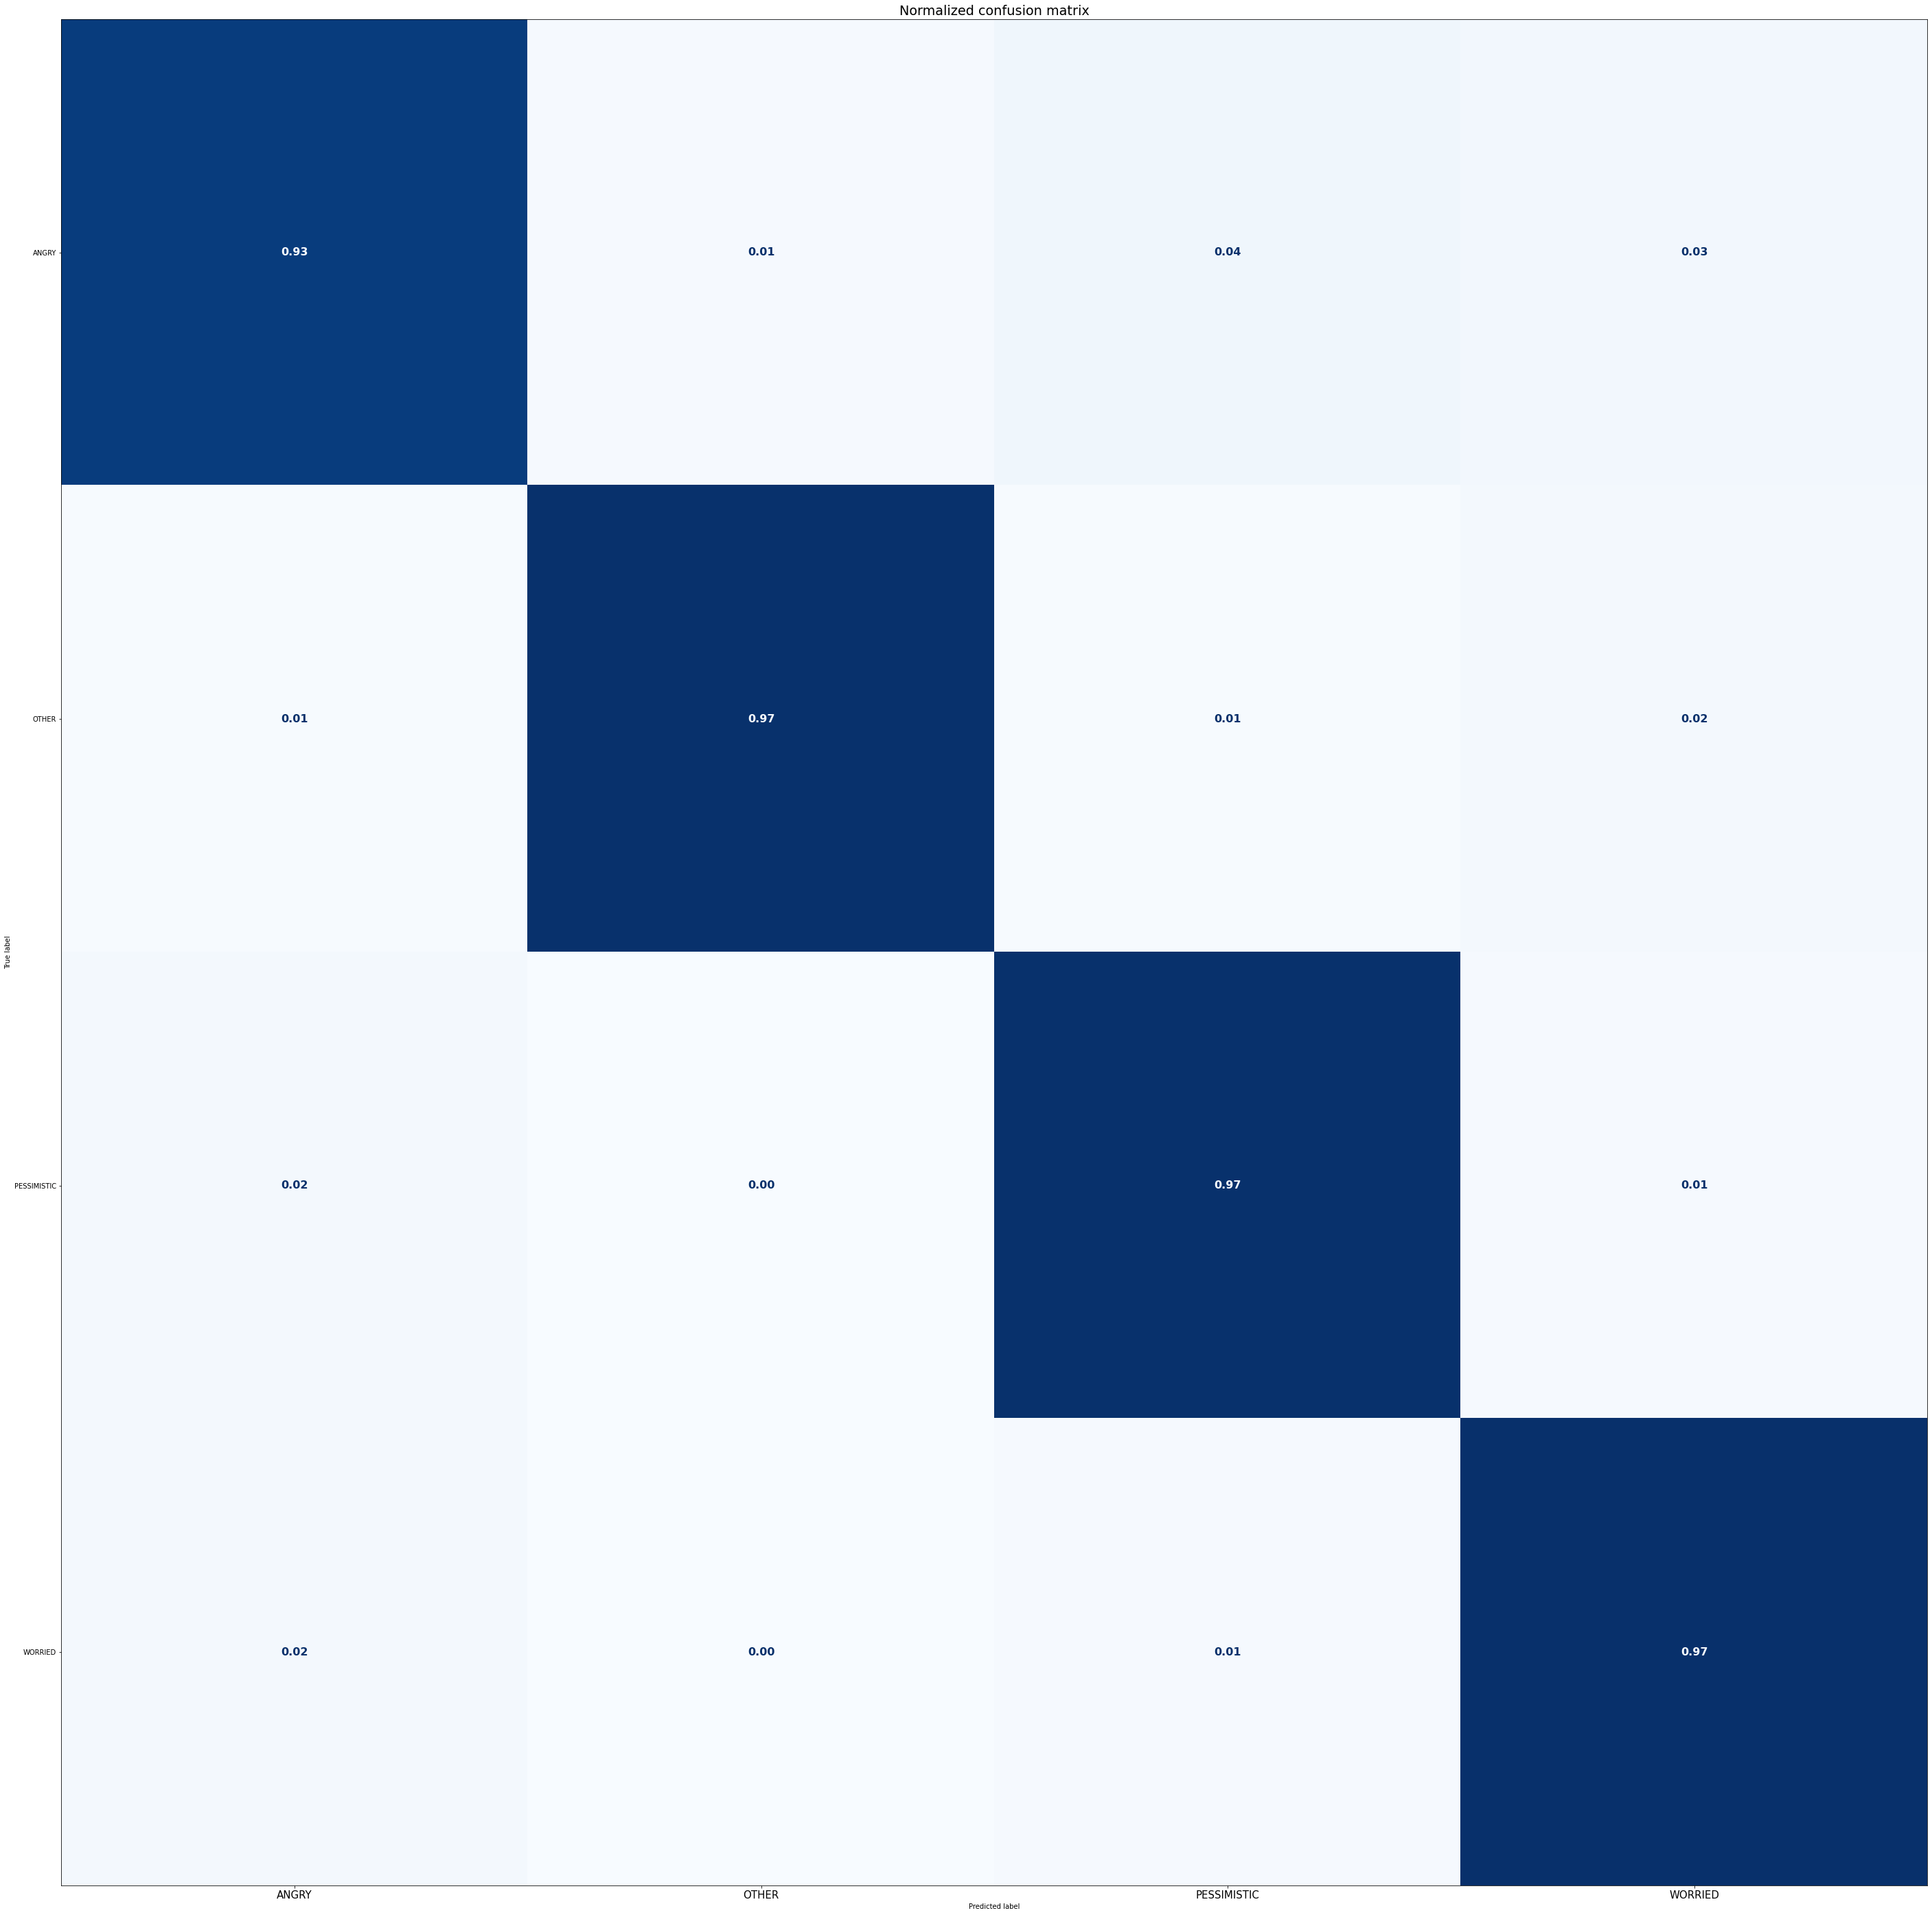

In [12]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(ds_enc["test"]["label"])
plot_confusion_matrix(y_preds, y_valid, labels.names)

In [13]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")     
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

ds_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
ds_enc["test"] = ds_enc["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [14]:
def label_int2str(row):
    return emotion["train"].features["label"].int2str(row)

In [15]:
ds_enc.set_format("pandas")
cols = ["text", 'emotion', "label", "predicted_label", "loss"]
df_test = ds_enc["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [16]:
loss_values = df_test.sort_values("loss", ascending=False).head(50)
loss_values

,text,emotion,label,predicted_label,loss
426,i feel unprotected a class post count link hre...,sadness,PESSIMISTIC,WORRIED,8.011029
150,im feeling rather angsty and listless,sadness,PESSIMISTIC,ANGRY,7.439035
816,whenever i put myself in others shoes and try ...,anger,ANGRY,OTHER,7.413682
611,i couldnt help feeling for him and this awful ...,sadness,PESSIMISTIC,ANGRY,7.371945
119,i feel like i know who most of them are by now...,joy,OTHER,PESSIMISTIC,7.353570
1538,i feel so wiggy about everything maybe ill jus...,joy,OTHER,PESSIMISTIC,7.243977
1928,i feel inside cause life is like a game someti...,fear,WORRIED,PESSIMISTIC,7.111045
1026,i have not conducted a survey but it is quite ...,sadness,PESSIMISTIC,WORRIED,6.640859
992,i do feel terribly remourseful that i didnt st...,love,OTHER,PESSIMISTIC,5.833686
1569,i feel lonely who make me feel special when i ...,sadness,PESSIMISTIC,OTHER,5.769806


In [17]:
loss_values.to_csv('loss_values_baseline_emotion_finetuning.tsv',header =True, sep = '\t',index=False)
df_test.to_csv('preds_baseline_emotion_finetuning.tsv',header =True, sep = '\t',index=False)